# PCA & LDA on MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import pandas as pd

## 1. Train KNN on MNIST Dataset

In [2]:
train_data = datasets.MNIST(root = './data/02/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './data/02/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/02/MNIST/raw/train-images-idx3-ubyte.gz to ./data/02/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/02/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/02/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/02/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/02/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/02/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/02/MNIST/raw

number of training data :  60000
number of test data :  10000


In [3]:
# 데이터 모양 확인을 위해 dataframe 형태로 변환

feat_cols = ['pixel'+str(i) for i in range(784)]
df_train = pd.DataFrame(train_data.data.reshape(60000,-1).numpy(), columns = feat_cols)
df_test = pd.DataFrame(test_data.data.reshape(10000,-1).numpy(), columns = feat_cols)

df_train.shape, df_test.shape

((60000, 784), (10000, 784))

In [4]:
df_train.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

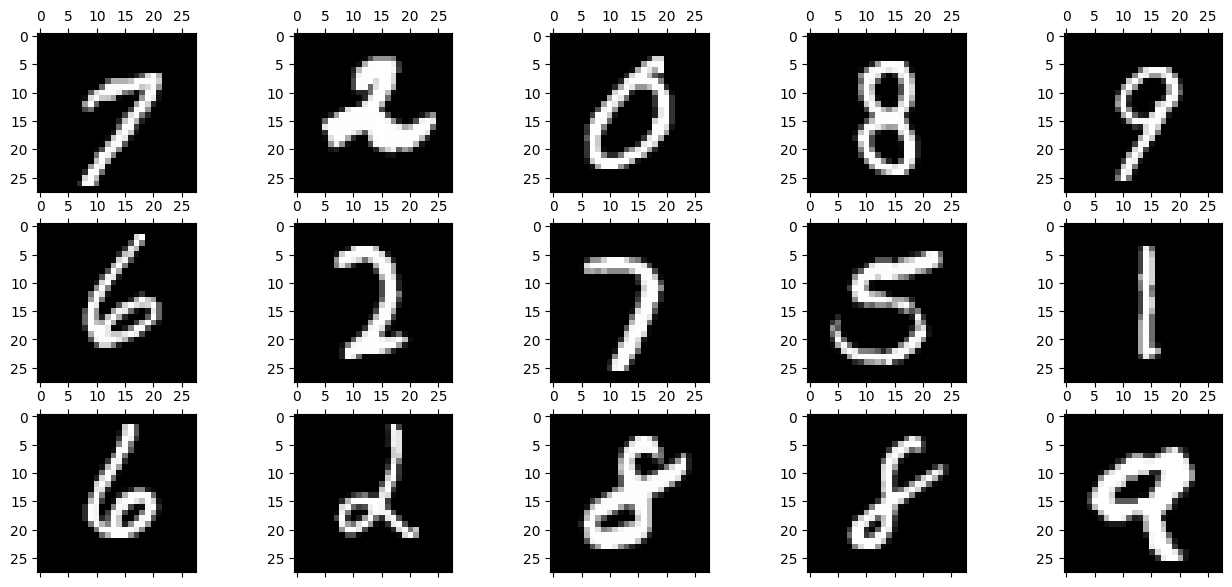

In [5]:
# 데이터 형태 시각화

import matplotlib.pyplot as plt
import numpy as np

rndperm = np.random.permutation(df_train.shape[0])

# Plot the graph
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    ax.matshow(df_train.loc[rndperm[i], feat_cols].values.reshape((28,28)).astype(float))
plt.show()

In [6]:
# 학습 데이터 준비

import numpy as np

X_train = train_data.data.reshape(60000,-1).numpy()
y_train = train_data.targets.numpy()

X_test = test_data.data.reshape(10000,-1).numpy()
y_test = test_data.targets.numpy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [7]:
# KNN 학습 - Baseline

from sklearn.neighbors import KNeighborsClassifier
import time

start_time = time.time()
clf = KNeighborsClassifier(n_neighbors= 5)
clf.fit(X_train, y_train)
print('Fit time : ', time.time() - start_time)

Fit time :  0.00762486457824707


In [8]:
from sklearn.metrics import accuracy_score

start_time = time.time()
pred = clf.predict(X_test)
print('Fit time : ', time.time() - start_time)
print(accuracy_score(y_test, pred))

Fit time :  16.475707054138184
0.9688


## 2. PCA & LDA 적용하기

In [73]:
# PCA 적용
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([ 
    ('pca', PCA(n_components=30)), 
])

# 훈련 데이터에 PCA 적용
X_train_pca = pipeline.fit_transform(X_train)

# 테스트 데이터에도 동일한 PCA 변환 적용
X_test_pca = pipeline.transform(X_test)

clf_pca = KNeighborsClassifier(n_neighbors= 5)
clf_pca.fit(X_train_pca, y_train)

KNeighborsClassifier()

In [65]:
# LDA 적용

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=5)  

X_train_lda = lda.fit_transform(X_train, y_train)



In [36]:
X_train_lda.shape

(60000, 2)

In [37]:
lda.explained_variance_ratio_

array([0.2392286 , 0.20180995])

## 3. 결과 비교하기

In [75]:
# PCA 결과
start_time = time.time()
pred = clf_pca.predict(X_test_pca)
print('Fit time : ', time.time() - start_time)
print(accuracy_score(y_test, pred))

Fit time :  0.745074987411499
0.9754


In [66]:
# LDA 결과
start_time = time.time()
y_pred = lda.predict(X_test)
print('Fit time : ', time.time() - start_time)
print(accuracy_score(y_test, y_pred))

Fit time :  0.04575514793395996
0.873


## 4. PCA & LDA 장단점 정리하기

####장단점을 자유롭게 적어주세요!

- PCA
  - 장점: 비지도 학습에 사용가능, 차원의 저주 감소
  - 단점: 분산에만 초점, 클래스 고려 x

- LDA
  - 장점: 클래스 분류에 최적화
  - 단점: 클래스의 선형 분리를 가정, 고차원의 데이터에는 부적합